# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('figure', figsize=(6,4))
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [3]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [4]:
data_dir = '../input/quora-insincere-questions-classification'
train_fname= data_dir + '/train.csv'
test_fname= data_dir + '/test.csv'
sub_fname= data_dir + '/sample_submission.csv'

# Analysis and Loading

In [5]:
raw_df=pd.read_csv(train_fname)
test_df=pd.read_csv(test_fname)

In [6]:
raw_df.question_text.sample(10).values[:5]

array(['How are attorneys like Bennet Kelley allowed to make false claims to the courts and illegally use his wife Wanda Rudd as a process server?',
       'How do I become successful after the age of 40?',
       'What is the best thing about the NBA?',
       'Do you use any wild west ring tones when you use a phone holster?',
       'Does having more money bring happiness?'], dtype=object)

In [7]:
test_df.question_text.sample(10).values[:5]

array(['How can I disable Indian answers on my feed?',
       'What game will replace chess and go as a way to amuse humans?',
       'How do you write a congratulations message to newly weds?',
       'How is ozone in the troposphere formed?',
       'What are some of the theories of continental drift?'],
      dtype=object)

In [8]:
sample_size=len(raw_df)
sample_df=raw_df.sample(sample_size)

In [9]:
sample_df.question_text.sample(10).values[:5]

array(['How would you use a Death Note to achieve world domination?',
       'Why do you think Canada is the best country in the world, why and how it should attract young people to stay there or move there?',
       'What does it mean if a Harvard admissions officer contacted on of my recommenders and had an interview with them about me?',
       'How do I become a construction valuation engineer?',
       'Is it possible to resume college studies after 10 years?'],
      dtype=object)

In [10]:
sample_df.target.value_counts(normalize=True)

target
0    0.93813
1    0.06187
Name: proportion, dtype: float64

# Preprocessing

## TF-IDF Vectorization

In [11]:
word_tokenize("testing, a lot, of punctuations!!")

['testing', ',', 'a', 'lot', ',', 'of', 'punctuations', '!', '!']

In [12]:
stemmer= SnowballStemmer(language='english')

In [13]:
stemmer.stem("butterflies"), stemmer.stem("doing"), stemmer.stem("really")

('butterfli', 'do', 'realli')

In [14]:
def tokenize(text):
    return [stemmer.stem(token) for token in word_tokenize(text)]

In [15]:
tokenize("testing tokenizer, really good enough!")

['test', 'token', ',', 'realli', 'good', 'enough', '!']

In [16]:
english_stopwords= stopwords.words('english')

In [17]:
vectorizer= TfidfVectorizer(tokenizer=tokenize,
                            stop_words=english_stopwords, max_features=1024)

In [18]:
%%time
vectorizer.fit(sample_df.question_text)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CPU times: user 10min 29s, sys: 753 ms, total: 10min 30s
Wall time: 10min 30s


TfidfVectorizer(max_features=1024,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x7cbc507825f0>)

In [19]:
vectorizer.get_feature_names_out()[:50]

array(['!', '$', '%', '&', "'", "''", "'m", "'s", '(', ')', ',', '-', '.',
       '1', '10', '100', '12', '12th', '15', '2', '20', '2017', '2018',
       '3', '30', '4', '5', '6', '7', '8', ':', '?', '[', ']', '``',
       'abl', 'abroad', 'abus', 'accept', 'access', 'accomplish',
       'accord', 'account', 'achiev', 'acid', 'act', 'action', 'activ',
       'actor', 'actual'], dtype=object)

## Transforming questions to vectors

In [20]:
%%time
input = vectorizer.transform(sample_df['question_text'])

CPU times: user 10min 32s, sys: 428 ms, total: 10min 33s
Wall time: 10min 33s


In [21]:
%%time
test_input = vectorizer.transform(test_df['question_text'])

CPU times: user 3min 1s, sys: 53 ms, total: 3min 1s
Wall time: 3min 1s


# Preparation for training

In [22]:
train_df, val_df, train_target, val_target= train_test_split(input, sample_df['target'], test_size=0.2)

## Converting to Pytorch Tensor

In [23]:
train_input_tensor= torch.tensor(train_df.toarray()).float()
val_input_tensor= torch.tensor(val_df.toarray()).float()

In [24]:
train_target_tensor= torch.tensor(train_target.values).float()
val_target_tensor=torch.tensor(val_target.values).float()

In [25]:
test_input_tensor= torch.tensor(test_input.toarray()).float()

## DataLoader

In [26]:
print(type(train_input_tensor))
print(type(train_target_tensor))
print(type(val_input_tensor))
print(type(val_target_tensor))
print(type(test_input_tensor))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [27]:
train_ds= TensorDataset(train_input_tensor, train_target_tensor)
val_ds= TensorDataset(val_input_tensor, val_target_tensor)
test_ds= TensorDataset(test_input_tensor)

In [28]:
train_dl= DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl= DataLoader(val_ds, batch_size=128)
test_dl= DataLoader(test_ds, batch_size=128)

# Model

In [29]:
class QuoraNet(nn.Module):
    def __init__(self):
        super(QuoraNet, self).__init__()
        self.layer1=nn.Linear(1024, 512)
        self.layer2=nn.Linear(512, 256)
        self.layer3=nn.Linear(256, 128)
        self.layer4=nn.Linear(128, 32)
        self.layer5=nn.Linear(32, 1)

    def forward(self, inputs):
        out=self.layer1(inputs)
        out= F.relu(out)
        out=self.layer2(out)
        out= F.relu(out)
        out=self.layer3(out)
        out= F.relu(out)
        out=self.layer4(out)
        out= F.relu(out)
        out=self.layer5(out)
        return out


In [30]:
model=QuoraNet()

In [31]:
for batch in train_dl:
    batch_inputs, batch_targets = batch
    print('inputs.shape:', batch_inputs.shape)
    print('targets.shape:', batch_targets.shape)
    
    batch_out = model(batch_inputs)
    print("batch_out.shape: ", batch_out.shape)


    #probability conversion
    probs = torch.sigmoid(batch_out[:,0])
    print("probs:", probs[:10])

    preds = (probs >= 0.5).int()
    print("preds: ", preds[:10])
    print("targets: ", batch_targets[:10])
    
    print('outputs', preds)
    print('accuracy', accuracy_score(batch_targets, preds))
    print('f1_score', f1_score(batch_targets, preds))

    #loss
    print("loss: ", F.binary_cross_entropy(preds.float(), batch_targets))
    break

inputs.shape: torch.Size([128, 1024])
targets.shape: torch.Size([128])
batch_out.shape:  torch.Size([128, 1])
probs: tensor([0.5131, 0.5134, 0.5132, 0.5132, 0.5133, 0.5130, 0.5130, 0.5132, 0.5130,
        0.5132], grad_fn=<SliceBackward0>)
preds:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
targets:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
outputs tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
accuracy 0.0546875
f1_score 0.1037037037037037
loss:  tensor(94.5312)


In [32]:
def evaluate(model, dl):
    losses, accs, f1s = [], [], []
    for batch in dl:
        inputs, targets = batch
        out = model(inputs)
        
        probs = torch.sigmoid(out[:,0])
        loss = F.binary_cross_entropy(probs, targets.float(), weight=torch.tensor(20.))
        losses.append(loss.item())

        preds = (probs > 0.5).int()
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds)
        
        accs.append(acc)
        f1s.append(f1)

    return np.mean(losses), np.mean(accs), np.mean(f1s)

In [33]:
evaluate(model, train_dl), evaluate(model, val_dl)

((14.331679597431279, 0.06183109535766781, 0.1157140633592155),
 (14.331484556782193, 0.062004430017965045, 0.11606698007523282))

In [34]:
def fit(epochs, lr, model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            inputs, targets = batch
            out = model(inputs)
            probs = torch.sigmoid(out[:,0])
            loss = F.binary_cross_entropy(probs, 
                                          targets.float(), 
                                          weight=torch.tensor(20.))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        loss, acc, f1 = result
        print('Epoch: {}; Loss: {:.4f}; Accuracy: {:.4f}; F1 Score: {:.4f}'.format(
            epoch, loss, acc, f1))
        history.append(result)

    return history

In [35]:
model=QuoraNet()

In [36]:
history = [evaluate(model, val_dl)]

In [37]:
history+=fit(10, 0.01, model, train_dl, val_dl)

Epoch: 0; Loss: 2.8096; Accuracy: 0.9492; F1 Score: 0.4490
Epoch: 1; Loss: 2.8134; Accuracy: 0.9489; F1 Score: 0.4896
Epoch: 2; Loss: 2.7949; Accuracy: 0.9483; F1 Score: 0.3770
Epoch: 3; Loss: 2.7794; Accuracy: 0.9497; F1 Score: 0.4943
Epoch: 4; Loss: 2.7866; Accuracy: 0.9494; F1 Score: 0.4853
Epoch: 5; Loss: 2.7749; Accuracy: 0.9494; F1 Score: 0.4867
Epoch: 6; Loss: 2.8067; Accuracy: 0.9473; F1 Score: 0.3189
Epoch: 7; Loss: 2.7806; Accuracy: 0.9495; F1 Score: 0.4510
Epoch: 8; Loss: 2.7877; Accuracy: 0.9494; F1 Score: 0.4254
Epoch: 9; Loss: 2.7923; Accuracy: 0.9484; F1 Score: 0.5035


In [38]:
history+=fit(5, 0.001, model, train_dl, val_dl)

Epoch: 0; Loss: 2.7968; Accuracy: 0.9494; F1 Score: 0.4739
Epoch: 1; Loss: 2.8232; Accuracy: 0.9489; F1 Score: 0.4840
Epoch: 2; Loss: 2.8530; Accuracy: 0.9483; F1 Score: 0.4858
Epoch: 3; Loss: 2.9212; Accuracy: 0.9478; F1 Score: 0.4789
Epoch: 4; Loss: 3.0665; Accuracy: 0.9459; F1 Score: 0.4735


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

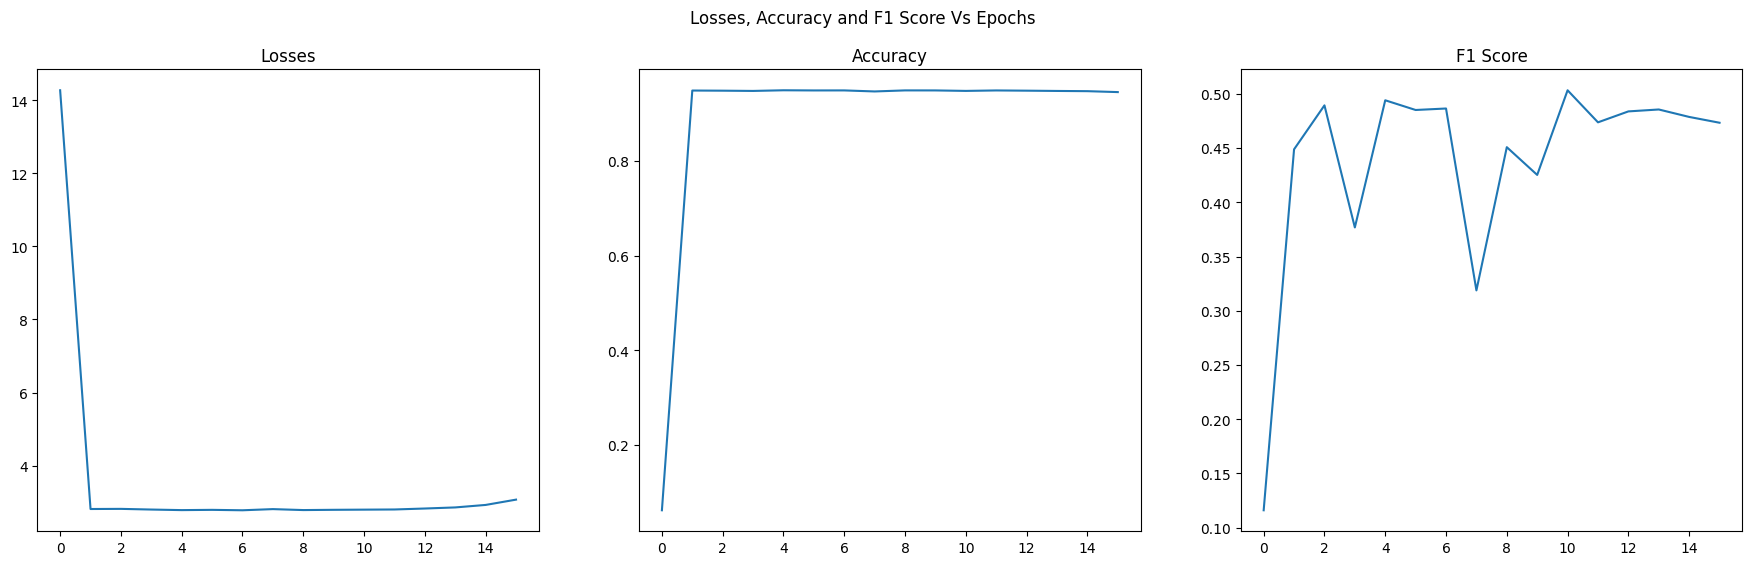

In [39]:
losses = [item[0] for item in history]
acc=[item[1] for item in history]
f1s = [item[2] for item in history]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))
fig.suptitle('Losses, Accuracy and F1 Score Vs Epochs')

sns.lineplot(losses, ax=axes[0])
axes[0].set_title('Losses')
sns.lineplot(acc, ax=axes[1])
axes[1].set_title('Accuracy')
sns.lineplot(f1s, ax=axes[2])
axes[2].set_title('F1 Score')
plt.show()

# Predictions on Kaggle Data

In [40]:
test_tensors = torch.tensor(test_input.toarray()).float()

In [41]:
test_ds = TensorDataset(test_tensors)
test_dl = DataLoader(test_ds, batch_size=128)

In [42]:
def predict(model, dl):
    all_preds = []
    for batch in dl:
        inputs, = batch
        out = model(inputs)
        probs = torch.sigmoid(out)[:,0]
        preds = (probs > 0.5).int()
        all_preds += list(preds.numpy())
    return all_preds

In [43]:
test_preds = predict(model, test_dl)

In [44]:
test_preds[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [45]:
sub_df=pd.read_csv(sub_fname)

In [46]:
sub_df.prediction = test_preds
sub_df.to_csv('submission.csv', index=None)